## 最小二乗法に対する深層展開型勾配法

by S. Takabe; DO NOT REDISTRIBUTE

解説記事（*****）の図を作成するコードに解説を加えたものです

動作環境：Goole Colab.での動作が楽です．GPUなしでも動作しますが遅くなります．


## 問題設定とアルゴリズム

$x\in\mathbb R^n$を原信号とし，
線形観測
$y=H^Tx$ ($y\in\mathbb R^m$,$H^T\in\mathbb R^{n\times m}$,$w\sim \mathcal N (\vec 0,\sigma^2 I_n)$)
で得られた$y$と$H$から$x$を最小二乗法で推定する

つまり，$\min_{x} \|y-H^Tx\|_2^2/2$を勾配法で解く

$\nabla  \|y-H^Tx\|_2^2/2 = H(y-H^Tx)$なので，更新式は
$x_{t+1} = x_t -\gamma_t H(y-H^Tx)$

深層展開型勾配法では，ランダム生成したデータセット$\{x,y\}$から，適切なステップサイズ列$\{\gamma_t\}$を学習する

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

device = "cuda" if torch.cuda.is_available() else "cpu" # 'cpu' or 'cuda'

In [2]:
## model parameters
itr = 10 # iteration steps $T$
total_itr = itr # max. iterations
n = 120
m = 180
##

## training parameters
bs = 100 # mini batch size

num_batch = 200 # number of mini batches
lr_adam = 1e-2 # learning rate of optimizer
init_val = 0.3 # initial values of $\gamma_t$
##

## parameters for evauation of generalization error
total_itr=itr*5 # total number of iterations (multiple number of "itr")
bs = 10000 # number of samples
##

### 目的関数の定義

ここでは，簡単のため行列$H$は固定する

グラム行列$A=HH^T$の最小固有値と最大固有値の比は条件数と呼ばれる

条件数が大きいほど勾配法の収束速度は遅くなる

In [3]:
# generate A and H
seed_ = 12
np.random.seed(seed=seed_)
H = np.random.normal(0,1.0/math.sqrt(n),(n,m))
A = np.dot(H,H.T)
eig = np.linalg.eig(A)
eig = eig[0] # eigenvalues

W = torch.Tensor(np.diag(eig)).to(device)
H = torch.from_numpy(H).float().to(device)

print("Aの条件数，最大固有値，最小固有値")
print(np.max(np.abs(eig))/np.min(np.abs(eig)),np.max(np.abs(eig)),np.min(np.abs(eig)))

# print(eig) #Aの固有値すべてを確認するとき


Aの条件数，最大固有値，最小固有値
96.74547801219069 4.739829001404537 0.048992770502485725


### 深層展開型勾配法の定義

以下では，ミニバッチ学習を行う．つまり，観測信号$y$から原信号$x$の推定を$bs$個並列的に行い，それらの損失関数を計算後，平均を取る．

このとき，$x$や$y$がサイズ $bs \times$ $n$(or $m$)のテンソルになるため，
行列ベクトル積を逆順にしている

$H^Tx\in\mathbb{R}^{m\times 1}$ $\Rightarrow$ $xH\in \mathbb{R}^{bs\times m}$

In [4]:
# gradient
def grad_numerical_f(x, bs):
    return (x@H-y)@H.T # H^T(Hx-y) ここが逆順

## DUGD
class DUGD(nn.Module):
    def __init__(self, num_itr):
        super(DUGD, self).__init__()
        self.gamma = nn.Parameter(init_val*torch.ones(num_itr)) # 学習可能ステップサイズの次元と初期値の指定
    def forward(self, num_itr, bs):
        traj = []
        s = torch.zeros(bs,n).to(device) # initial point
        traj.append(s)
        for i in range(num_itr):
            j = i % itr # 学習パラメタを使いまわし（周期的に利用）するため
            s = s - abs(self.gamma[j]) * grad_numerical_f(s, bs) # 勾配法の更新式
            traj.append(s)
        return s, traj

model = DUGD(itr).to(device)
loss_func = nn.MSELoss() #損失関数は平均二乗誤差
opt= optim.Adam(model.parameters(), lr=lr_adam)

### 学習部分

ここでは各ミニバッチによる学習パラメタの更新時に，データ$\{x,y\}$をランダムに生成している

また，インクリメンタルトレーニングというテクニックを用いている

＊インクリメンタルトレーニング：深層展開したアルゴリズム$T$層分を一括で学習するのではなく，1層である程度学習，その後に2層で学習…というように学習する層数を増加させる学習法

Ref. Ito, Takabe, Wadayama, IEEE Trans. Sig. Process.
https://ieeexplore.ieee.org/document/8695874

（学習パラメタの勾配消失や好ましくない極小点への収束を防ぐ効果がある）

In [5]:
## training process of DUGD
# it takes about several minutes on Google Colaboratory

loss_gen=[]
for gen in (range(itr)): # インクリメンタルトレーニングのループ
    for i in range(num_batch): # 1ミニバッチを使った学習パラメタの更新
        opt.zero_grad()
        solution = 2*torch.bernoulli(0.5* torch.ones(bs,n)).to(device)-1 #原信号xの生成

        y = solution @ H + 0.01*torch.randn(m).to(device) # xに対応するyの生成
        x_hat,_ = model(gen + 1, bs) # DUGDによるxの推定
        loss  = loss_func(x_hat, solution) # 推定したx_hatと正解x間の損失
        loss.backward() # 誤差逆伝搬
        opt.step() # 学習パラメタ更新
        if i % 50 == 0:
            print("generation:",gen+1, " batch:",i, "\t MSE loss:",loss.item() ) #学習時の損失関数の表示
    loss_gen.append(loss.item())


generation: 1  batch: 0 	 MSE loss: 0.4397895932197571
generation: 1  batch: 50 	 MSE loss: 0.40107262134552
generation: 1  batch: 100 	 MSE loss: 0.4017025828361511
generation: 1  batch: 150 	 MSE loss: 0.40143823623657227
generation: 2  batch: 0 	 MSE loss: 0.26809126138687134
generation: 2  batch: 50 	 MSE loss: 0.21398457884788513
generation: 2  batch: 100 	 MSE loss: 0.21357424557209015
generation: 2  batch: 150 	 MSE loss: 0.2137378752231598
generation: 3  batch: 0 	 MSE loss: 0.15753060579299927
generation: 3  batch: 50 	 MSE loss: 0.13052421808242798
generation: 3  batch: 100 	 MSE loss: 0.12591774761676788
generation: 3  batch: 150 	 MSE loss: 0.1261765956878662
generation: 4  batch: 0 	 MSE loss: 0.09691686183214188
generation: 4  batch: 50 	 MSE loss: 0.08389811217784882
generation: 4  batch: 100 	 MSE loss: 0.08059056848287582
generation: 4  batch: 150 	 MSE loss: 0.078635074198246
generation: 5  batch: 0 	 MSE loss: 0.06390339136123657
generation: 5  batch: 50 	 MSE loss: 

In [6]:
# learned gamma（学習された$\gamma_t$の値）
print("#_ n=", n, "m=",m, "itr=",itr, "bs=", bs, "num_batch=", num_batch,
      "learning_rate=", lr_adam,"seed=",seed_ ,"lmax=", np.max(eig),"lmin=", np.min(eig), "kappa=",np.max(eig)/np.min(eig),"init_val=",init_val  )
print("#_ t, learned $\gamma_t$")
for i in range(itr):
    print(i+1, model.gamma[i].item())

#_ n= 120 m= 180 itr= 10 bs= 10000 num_batch= 200 learning_rate= 0.01 seed= 12 lmax= 4.739829001404537 lmin= 0.048992770502485725 kappa= 96.74547801219069 init_val= 0.3
#_ t, learned $\gamma_t$
1 3.4702019691467285
2 0.21162699162960052
3 3.495422601699829
4 0.22381123900413513
5 1.2526021003723145
6 0.2507171034812927
7 0.716062605381012
8 0.29518964886665344
9 0.48826831579208374
10 0.36678096652030945


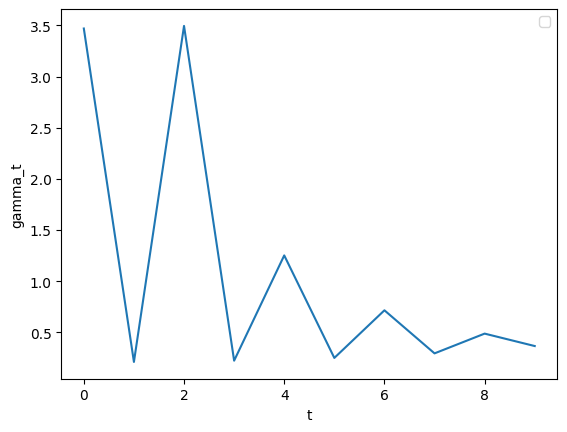

In [7]:
# learned gamma（学習された$\gamma_t$の値）の図示
import matplotlib.pyplot as plt

plt.plot(np.arange(itr), model.gamma.to("cpu").detach().numpy())
plt.xlabel('t')
plt.ylabel('gamma_t')
plt.legend()
plt.show()

### 汎化誤差の評価

最適な定数ステップサイズを用いた勾配法と収束性能を比較する

In [8]:
## naive GD with a constant step size
class GD(nn.Module):
    def __init__(self, num_itr):
        super(GD, self).__init__()
    def forward(self, num_itr, bs, gamma):
        traj = []
        s  = torch.zeros(bs,n).to(device)
        traj.append(s)

        for i in range(num_itr):
            s = s - abs(gamma) * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj
gd_model = GD(itr).to(device)


In [9]:
## Evaluation of error（汎化誤差見積もり）
total_itr = 160
#原信号xとyの生成
#solution = torch.normal(0.0*torch.ones(bs,n),1.0).to(device).detach()
solution = 2*torch.bernoulli(0.5* torch.ones(bs,n)).to(device)-1
y = solution@H.detach()+ 0.01*torch.randn(m).to(device)

## trained DUGD

norm_list_DUGD = []
itr_list = []
for i in range(total_itr+1):
    s_hat,_ = model(i, bs)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_DUGD.append(err)
    itr_list.append(i)

## naive GD
gamma = 2.0/(np.max(eig)+np.min(eig)) # optimal constant step size
norm_list_GD = []
for i in range(total_itr+1):

    s_hat, _ = gd_model(i, bs, gamma)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_GD.append(err)

# LMMSE
norm_LMMSE = (torch.norm(solution.to(device) - y@torch.linalg.pinv(H))**2).item()/(n*bs)

# generalization error (MSE)
print("#_ generalization error (MSE)")
print("#_ itr, DUGD, GD")
for i in range(total_itr+1):
    print(i,"{:.5e} {:.5e}".format(norm_list_DUGD[i], norm_list_GD[i]) )

#_ generalization error (MSE)
#_ itr, DUGD, GD
0 1.00000e+00 1.00000e+00
1 3.52256e+01 4.02813e-01
2 5.17279e+00 2.60207e-01
3 2.73551e+02 1.91695e-01
4 4.43470e+01 1.50583e-01
5 1.77816e+02 1.22939e-01
6 2.08345e+01 1.02989e-01
7 1.14307e+01 8.78785e-02
8 6.21103e-01 7.60278e-02
9 3.85522e-02 6.64861e-02
10 9.37058e-03 5.86500e-02
11 6.47349e-02 5.21090e-02
12 9.80235e-03 4.65816e-02
13 3.06471e-01 4.18576e-02
14 4.59494e-02 3.77875e-02
15 1.84792e-01 3.42503e-02
16 2.13252e-02 3.11593e-02
17 1.31684e-02 2.84385e-02
18 2.39425e-03 2.60349e-02
19 1.78681e-03 2.38974e-02
20 1.68620e-03 2.19926e-02
21 1.35131e-03 2.02842e-02
22 1.09850e-03 1.87509e-02
23 1.33191e-03 1.73656e-02
24 8.09908e-04 1.61147e-02
25 9.63868e-04 1.49775e-02
26 6.82433e-04 1.39453e-02
27 6.35436e-04 1.30016e-02
28 6.05148e-04 1.21413e-02
29 5.82398e-04 1.13508e-02
30 5.66618e-04 1.06275e-02
31 4.38953e-04 9.95982e-03
32 4.32007e-04 9.34691e-03
33 3.52730e-04 8.77882e-03
34 3.47653e-04 8.25586e-03
35 3.28607e-04 7.7

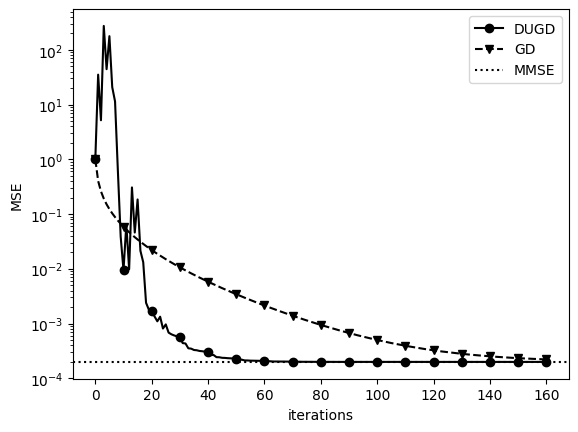

In [10]:
test = plt.figure()
plt.plot(itr_list, norm_list_DUGD,marker='o',markersize=6,c='black',markevery=10, label="DUGD")
plt.plot(itr_list, norm_list_GD,"--",marker='v',markersize=6,c='black',markevery=10, label="GD")
plt.axhline(y=norm_LMMSE, xmin=0, xmax=160,ls=":", color="black", label="MMSE")

plt.xlabel('iterations')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
test.show()

# 図のダウンロード
#from google.colab import files
#plt.savefig("DUGD_1.pdf",bbox_inches="tight")
#files.download("DUGD_1.pdf")


## 応用課題（$x\in\{\pm 1\}^n$の場合）

原信号が2値の場合に，それを推定する以下のアルゴリズムbDUGD_roundを考える：

$r_t = x_t -\gamma_t H(y-H^Tx)$

$x_{t+1}=\eta(r_t)$

ただし，$\eta(r_t) = -1\, (x<0),\, 1\, (\mbox{o.w.})$とする．

また，$\eta$をソフト化した，

$r_t = x_t -\gamma_t H(y-H^Tx)$

$x_{t+1}=\tanh(2 x_t)$

をbDUGD_softと呼ぶ．

以下では，$(n,m)=(120,100)$の場合に，両者のステップサイズを深層展開で学習する．


In [15]:
n = 120
m = 100
lr_adam = 0.01

np.random.seed(seed=seed_)
H = np.random.normal(0,1.0/math.sqrt(n),(n,m))
A = np.dot(H,H.T)
eig = np.linalg.eig(A)
eig = eig[0] # eigenvalues

W = torch.Tensor(np.diag(eig)).to(device)
H = torch.from_numpy(H).float().to(device)

## DUGD
class bDUGD_soft(nn.Module):
    def __init__(self, num_itr):
        super(bDUGD_soft, self).__init__()
        self.gamma = nn.Parameter(init_val*torch.ones(num_itr)) # 学習可能ステップサイズの次元と初期値の指定
    def forward(self, num_itr, bs):
        traj = []
        s = torch.zeros(bs,n).to(device) # initial point
        traj.append(s)
        for i in range(num_itr):
            j = i % itr

            s = s - abs(self.gamma[j]) * grad_numerical_f(s, bs) # 勾配法の更新式
            s = torch.tanh(2*s)

            traj.append(s)
        return s, traj

class bDUGD_round(nn.Module):
    def __init__(self, num_itr):
        super(bDUGD_round, self).__init__()
        self.gamma = nn.Parameter(init_val*torch.ones(num_itr)) # 学習可能ステップサイズの次元と初期値の指定
    def forward(self, num_itr, bs):
        traj = []
        s = torch.zeros(bs,n).to(device) # initial point
        traj.append(s)
        for i in range(num_itr):
            j = i % itr

            s = s - abs(self.gamma[j]) * grad_numerical_f(s, bs) # 勾配法の更新式
            s = torch.sign(s)

            traj.append(s)
        return s, traj

model = bDUGD_soft(itr).to(device)
model_b = bDUGD_round(itr).to(device)
loss_func = nn.MSELoss() #損失関数は平均二乗誤差
opt   = optim.Adam(model.parameters(), lr=lr_adam)
opt2   = optim.Adam(model_b.parameters(), lr=lr_adam)

In [19]:
## training process of DUGD
# it takes about several minutes on Google Colaboratory

loss_gen=[]
for gen in (range(itr)): # インクリメンタルトレーニングのループ
    for i in range(num_batch): # 1ミニバッチを使った学習パラメタの更新
        opt.zero_grad()
        opt2.zero_grad()
        solution = 2*torch.bernoulli(0.5* torch.ones(bs,n)).to(device)-1 #原信号xの生成
        y = solution @ H + 0.01*torch.randn(m).to(device)# xに対応するyの生成
        x_hat,_ = model(gen + 1, bs) # DUGDによるxの推定
        loss  = loss_func(x_hat, solution) # 推定したx_hatと正解x間の損失
        loss.backward() # 誤差逆伝搬
        opt.step() # 学習パラメタ更新
        x_hat,_ = model_b(gen + 1, bs) # DUGDによるxの推定
        loss_b  = loss_func(x_hat, solution) # 推定したx_hatと正解x間の損失
        loss_b.backward() # 誤差逆伝搬
        opt2.step() # 学習パラメタ更新
        if i % 50 == 0:
            print("generation:",gen+1, " batch:",i, "\t soft MSE loss:",loss.item(),"\t round MSE loss:",loss_b.item())
    loss_gen.append(loss.item())


generation: 1  batch: 0 	 soft MSE loss: 0.6266266703605652 	 round MSE loss: 0.7306333184242249
generation: 1  batch: 50 	 soft MSE loss: 0.5124971270561218 	 round MSE loss: 0.7319766879081726
generation: 1  batch: 100 	 soft MSE loss: 0.5111877918243408 	 round MSE loss: 0.7294366359710693
generation: 1  batch: 150 	 soft MSE loss: 0.5108184218406677 	 round MSE loss: 0.7299399971961975
generation: 2  batch: 0 	 soft MSE loss: 0.6293246746063232 	 round MSE loss: 0.7273566722869873
generation: 2  batch: 50 	 soft MSE loss: 0.3170633912086487 	 round MSE loss: 0.7268833518028259
generation: 2  batch: 100 	 soft MSE loss: 0.3145696818828583 	 round MSE loss: 0.728523313999176
generation: 2  batch: 150 	 soft MSE loss: 0.3128007650375366 	 round MSE loss: 0.7287333607673645
generation: 3  batch: 0 	 soft MSE loss: 0.21186482906341553 	 round MSE loss: 0.7276899814605713
generation: 3  batch: 50 	 soft MSE loss: 0.19160449504852295 	 round MSE loss: 0.7278199791908264
generation: 3  bat

In [21]:
## Evaluation of c error（汎化誤差見積もり）
total_itr = 200

#原信号xとyの生成
solution = 2*torch.bernoulli(0.5* torch.ones(bs,n)).to(device).detach()-1
y = solution@H.detach()+ 0.01*torch.randn(m).to(device)

## trained DUGD

norm_list_DUGD = []
norm_list_DUGD_b = []
itr_list = []
for i in range(total_itr+1):
    s_hat,_ = model(i, bs)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_DUGD.append(err)
    s_hat,_ = model_b(i, bs)
    err_b = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_DUGD_b.append(err_b)
    itr_list.append(i)

## naive GD
gamma = 2.0/(np.max(eig)+np.min(eig)) # optimal constant step size
norm_list_GD = []
for i in range(total_itr+1):

    s_hat, _ = gd_model(i, bs, gamma)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_GD.append(err)


# generalization error (MSE)
print("#_ generalization error (MSE)")
print("#_ itr, DUGD, GD")
for i in range(total_itr+1):
    print(i,"{:.5e} {:.5e}".format(norm_list_DUGD[i], norm_list_GD[i]) )

#_ generalization error (MSE)
#_ itr, DUGD, GD
0 1.00000e+00 1.00000e+00
1 5.84395e-01 5.53284e-01
2 3.44248e-01 4.42528e-01
3 2.04143e-01 3.86803e-01
4 1.21574e-01 3.51996e-01
5 5.75371e-02 3.27767e-01
6 2.17308e-02 3.09736e-01
7 1.01211e-02 2.95692e-01
8 3.99197e-03 2.84383e-01
9 2.43265e-03 2.75045e-01
10 1.58701e-03 2.67180e-01
11 1.81390e-03 2.60452e-01
12 1.64575e-03 2.54617e-01
13 1.44232e-03 2.49505e-01
14 1.68065e-03 2.44981e-01
15 1.33667e-03 2.40947e-01
16 1.65465e-03 2.37324e-01
17 1.28109e-03 2.34050e-01
18 1.63075e-03 2.31076e-01
19 1.53540e-03 2.28360e-01
20 1.23382e-03 2.25870e-01
21 1.65434e-03 2.23577e-01
22 1.54876e-03 2.21459e-01
23 1.37363e-03 2.19496e-01
24 1.61620e-03 2.17670e-01
25 1.28285e-03 2.15968e-01
26 1.61185e-03 2.14377e-01
27 1.24673e-03 2.12888e-01
28 1.60180e-03 2.11488e-01
29 1.50781e-03 2.10173e-01
30 1.21141e-03 2.08932e-01
31 1.63605e-03 2.07761e-01
32 1.53550e-03 2.06653e-01
33 1.36583e-03 2.05605e-01
34 1.60988e-03 2.04610e-01
35 1.28150e-03 2.0

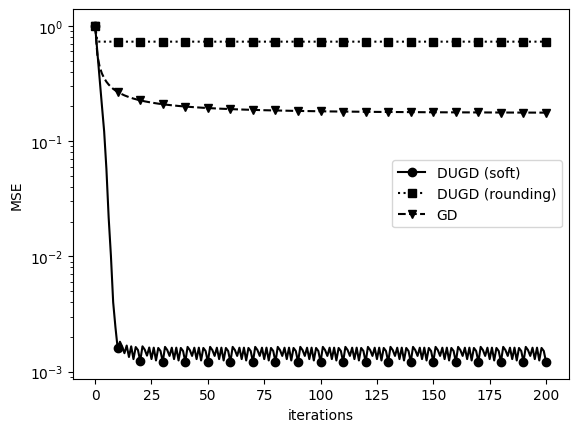

In [22]:
test = plt.figure()
plt.plot(itr_list, norm_list_DUGD,marker='o',markersize=6,c='black',markevery=10, label="DUGD (soft)")
plt.plot(itr_list, norm_list_DUGD_b,":",marker='s',markersize=6,c='black',markevery=10, label="DUGD (rounding)")
plt.plot(itr_list, norm_list_GD,"--",marker='v',markersize=6,c='black',markevery=10, label="GD")
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
test.show()

bDUGD_roundは学習によって性能が向上しない．そもそも損失関数の値が下がらず学習に失敗していることが分かる．これは丸め操作がほぼ至る所で微分値が零のため，パラメタ更新における誤差逆伝搬中で勾配が零になってしまうためである．

一方，bDUGD_softは丸め操作を適当にソフト化したため，学習の効果が表れている．
より性能を向上するには$\beta$を学習可能にする，tanhの代わりにニューラルネットに置き換えるなど様々な方法が考えられる．

以上の例は無線通信におけるMIMO（多入力多出力）通信路における信号推定の特殊ケースになっており，我々のグループでTrainable Projected Gradient descent (TPG) detectorとして提案したものです [Takabe et al. IEEE Acess, 2019]

